In [1]:
!pip install kaggle

In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file {name}'.format(name=fn))

!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file kaggle.json


In [3]:
!kaggle --version

Kaggle API 1.5.12


In [4]:
!ls /root/.kaggle

kaggle.json


In [5]:
!kaggle datasets download -d anefiamutiaraatha/dataset-tanaman-herbal

100% 3.34G/3.35G [00:16<00:00, 134MB/s]
100% 3.35G/3.35G [00:16<00:00, 219MB/s]


In [6]:
!unzip dataset-tanaman-herbal.zip

Archive:  dataset-tanaman-herbal.zip
  inflating: DATASET TANAMAN HERBAL/Data Testing/Daun Jambu Biji/jambu biji (100).JPG  
  inflating: DATASET TANAMAN HERBAL/Data Testing/Daun Jambu Biji/jambu biji (81).JPG  
  inflating: DATASET TANAMAN HERBAL/Data Testing/Daun Jambu Biji/jambu biji (82).JPG  
  inflating: DATASET TANAMAN HERBAL/Data Testing/Daun Jambu Biji/jambu biji (83).JPG  
  inflating: DATASET TANAMAN HERBAL/Data Testing/Daun Jambu Biji/jambu biji (84).JPG  
  inflating: DATASET TANAMAN HERBAL/Data Testing/Daun Jambu Biji/jambu biji (85).JPG  
  inflating: DATASET TANAMAN HERBAL/Data Testing/Daun Jambu Biji/jambu biji (86).JPG  
  inflating: DATASET TANAMAN HERBAL/Data Testing/Daun Jambu Biji/jambu biji (87).JPG  
  inflating: DATASET TANAMAN HERBAL/Data Testing/Daun Jambu Biji/jambu biji (88).JPG  
  inflating: DATASET TANAMAN HERBAL/Data Testing/Daun Jambu Biji/jambu biji (89).JPG  
  inflating: DATASET TANAMAN HERBAL/Data Testing/Daun Jambu Biji/jambu biji (90).JPG  
  inf

In [51]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras import Model
import matplotlib.pyplot as plt
from keras_preprocessing import image
from tensorflow.keras.applications.xception import preprocess_input
import numpy as np
import pathlib

In [8]:
TRAINING_DIR = "/content/DATASET TANAMAN HERBAL/Data Training/"
TESTING_DIR = "/content/DATASET TANAMAN HERBAL/Data Testing/"

In [30]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=32, 
                                                      class_mode='categorical',
                                                      target_size=(224, 224))
test_datagen = ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_directory(directory=TESTING_DIR,
                                                                batch_size=32, 
                                                                class_mode="categorical",
                                                                target_size=(224, 224))

Found 800 images belonging to 10 classes.
Found 200 images belonging to 10 classes.


In [31]:
train_dataset = image_dataset_from_directory(
    TRAINING_DIR,
    batch_size=32,
    image_size=(224,224),
    shuffle=True
)

Found 800 files belonging to 10 classes.


In [32]:
class_names = train_dataset.class_names

print(class_names)

['Daun Jambu Biji', 'Daun Kari', 'Daun Kemangi', 'Daun Kunyit', 'Daun Mint', 'Daun Pepaya', 'Daun Sirih', 'Daun Sirsak', 'Lidah Buaya', 'Teh Hijau']


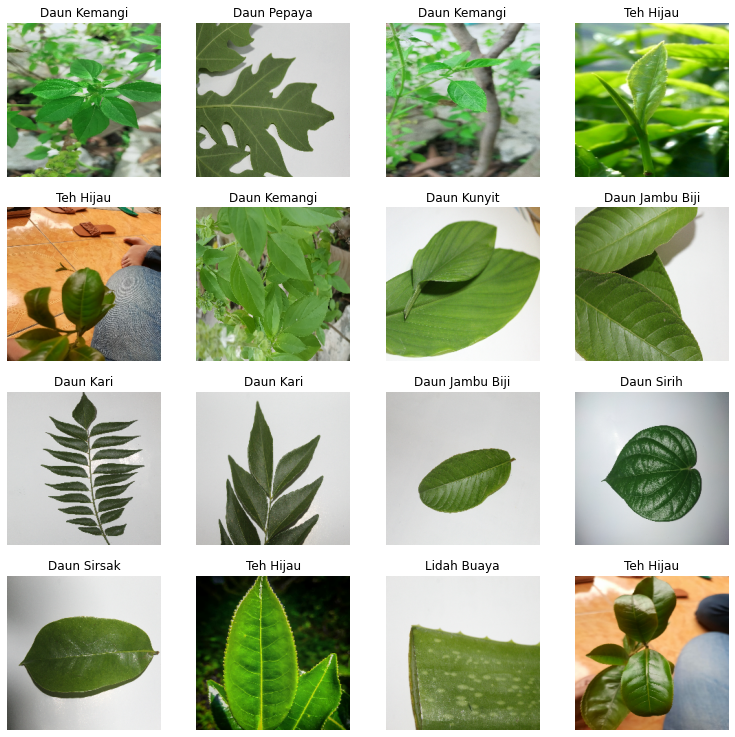

In [33]:
plt.figure(figsize=(13, 13))
for images, labels in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [34]:
pretrained_model = InceptionV3(input_shape = (224, 224, 3),
                                include_top = False,
                                weights = 'imagenet')

In [35]:
for layer in pretrained_model.layers:
    layer.trainable = False

In [36]:
last_layer = pretrained_model.get_layer('mixed5')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 12, 12, 768)


In [37]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense(10, activation='softmax')(x)

In [38]:
model = Model(pretrained_model.input, x)

In [39]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_98 (Conv2D)             (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 111, 111, 32  96         ['conv2d_98[0][0]']              
 ormalization)                  )                                                           

In [40]:
history = model.fit(train_generator, 
                     epochs=20, 
                     steps_per_epoch=10, 
                     validation_data=test_generator, 
                     validation_steps=3,
                     verbose=1)

Epoch 1/20
10/10 [==============================] - 113s 11s/step - loss: 3.5391 - accuracy: 0.2594 - val_loss: 1.5592 - val_accuracy: 0.6146
Epoch 2/20
10/10 [==============================] - 101s 10s/step - loss: 1.0483 - accuracy: 0.6531 - val_loss: 1.3310 - val_accuracy: 0.6458
Epoch 3/20
10/10 [==============================] - 99s 10s/step - loss: 0.6037 - accuracy: 0.8062 - val_loss: 0.4981 - val_accuracy: 0.8229
Epoch 4/20
10/10 [==============================] - 101s 11s/step - loss: 0.3337 - accuracy: 0.8938 - val_loss: 0.4471 - val_accuracy: 0.8229
Epoch 5/20
10/10 [==============================] - 100s 10s/step - loss: 0.2460 - accuracy: 0.9125 - val_loss: 0.7180 - val_accuracy: 0.8333
Epoch 6/20
10/10 [==============================] - 98s 10s/step - loss: 0.2211 - accuracy: 0.9281 - val_loss: 0.5587 - val_accuracy: 0.8021
Epoch 7/20
10/10 [==============================] - 100s 10s/step - loss: 0.1364 - accuracy: 0.9656 - val_loss: 0.3231 - val_accuracy: 0.8958
Epoch 8/

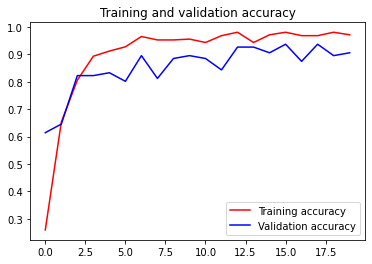

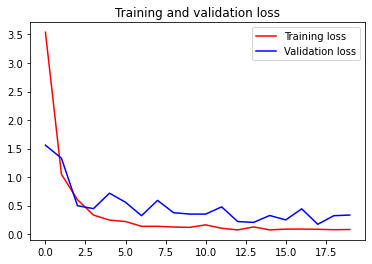

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc)) # Get number of epochs

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [43]:
loss = model.evaluate(test_generator, steps=10)

10/10 [==============================] - 35s 3s/step - loss: 0.2953 - accuracy: 0.9000


Saving teh hijau.jpg to teh hijau.jpg
Saving lidah buaya.jpg to lidah buaya.jpg
Saving daun sirsak.jpg to daun sirsak.jpg
Saving daun sirih.jpg to daun sirih.jpg
Saving daun mint.jpeg to daun mint.jpeg
Saving daun kunyit.jpg to daun kunyit.jpg
Saving daun kemangi.jpg to daun kemangi.jpg
Saving daun kari.webp to daun kari.webp
Saving daun pepaya.webp to daun pepaya (1).webp
Saving daunjb.jpg to daunjb.jpg


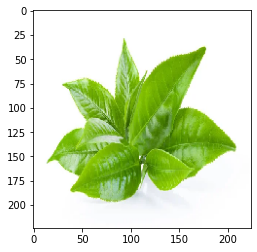

Daun Jambu Biji: 0.40%
Daun Kari: 0.08%
Daun Kemangi: 62.63%
Daun Kunyit: 1.39%
Daun Mint: 10.35%
Daun Pepaya: 0.53%
Daun Sirih: 4.42%
Daun Sirsak: 0.14%
Lidah Buaya: 0.29%
Teh Hijau: 19.79%


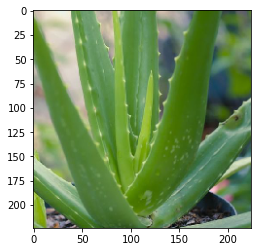

Daun Jambu Biji: 0.01%
Daun Kari: 0.01%
Daun Kemangi: 0.01%
Daun Kunyit: 0.01%
Daun Mint: 0.02%
Daun Pepaya: 0.00%
Daun Sirih: 0.00%
Daun Sirsak: 0.00%
Lidah Buaya: 99.15%
Teh Hijau: 0.79%


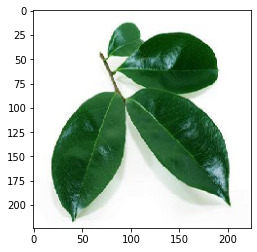

Daun Jambu Biji: 6.33%
Daun Kari: 0.18%
Daun Kemangi: 3.99%
Daun Kunyit: 1.24%
Daun Mint: 2.06%
Daun Pepaya: 2.07%
Daun Sirih: 13.82%
Daun Sirsak: 16.80%
Lidah Buaya: 0.05%
Teh Hijau: 53.45%


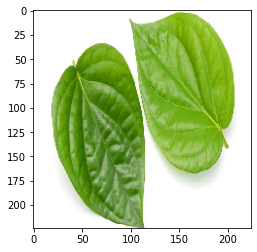

Daun Jambu Biji: 2.83%
Daun Kari: 0.01%
Daun Kemangi: 0.03%
Daun Kunyit: 0.16%
Daun Mint: 0.19%
Daun Pepaya: 0.01%
Daun Sirih: 96.63%
Daun Sirsak: 0.02%
Lidah Buaya: 0.02%
Teh Hijau: 0.09%


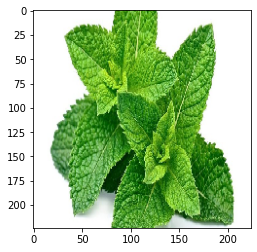

Daun Jambu Biji: 0.02%
Daun Kari: 0.00%
Daun Kemangi: 0.04%
Daun Kunyit: 0.00%
Daun Mint: 99.57%
Daun Pepaya: 0.06%
Daun Sirih: 0.01%
Daun Sirsak: 0.00%
Lidah Buaya: 0.01%
Teh Hijau: 0.28%


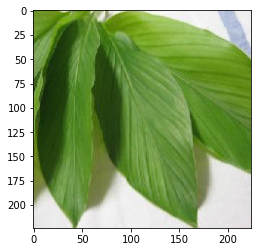

Daun Jambu Biji: 11.44%
Daun Kari: 0.00%
Daun Kemangi: 0.08%
Daun Kunyit: 88.15%
Daun Mint: 0.27%
Daun Pepaya: 0.00%
Daun Sirih: 0.00%
Daun Sirsak: 0.00%
Lidah Buaya: 0.02%
Teh Hijau: 0.04%


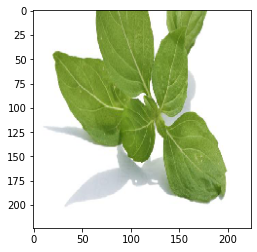

Daun Jambu Biji: 2.25%
Daun Kari: 8.60%
Daun Kemangi: 61.26%
Daun Kunyit: 0.76%
Daun Mint: 0.28%
Daun Pepaya: 24.93%
Daun Sirih: 0.29%
Daun Sirsak: 0.00%
Lidah Buaya: 0.03%
Teh Hijau: 1.59%


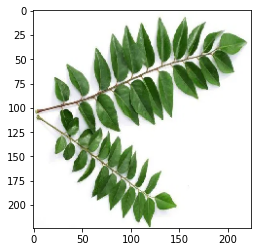

Daun Jambu Biji: 0.27%
Daun Kari: 22.64%
Daun Kemangi: 1.14%
Daun Kunyit: 0.00%
Daun Mint: 0.01%
Daun Pepaya: 72.14%
Daun Sirih: 0.00%
Daun Sirsak: 0.00%
Lidah Buaya: 0.00%
Teh Hijau: 3.79%


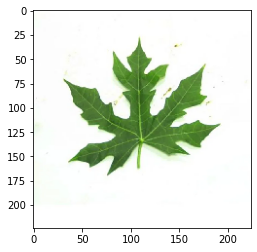

Daun Jambu Biji: 0.00%
Daun Kari: 0.02%
Daun Kemangi: 0.27%
Daun Kunyit: 0.00%
Daun Mint: 0.01%
Daun Pepaya: 99.62%
Daun Sirih: 0.00%
Daun Sirsak: 0.00%
Lidah Buaya: 0.00%
Teh Hijau: 0.07%


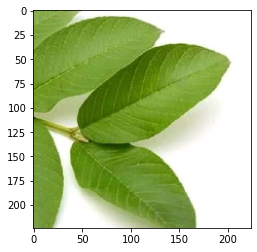

Daun Jambu Biji: 94.83%
Daun Kari: 0.00%
Daun Kemangi: 0.02%
Daun Kunyit: 3.90%
Daun Mint: 0.83%
Daun Pepaya: 0.02%
Daun Sirih: 0.12%
Daun Sirsak: 0.00%
Lidah Buaya: 0.02%
Teh Hijau: 0.27%


In [53]:
labels = train_generator.class_indices.keys()
uploaded = files.upload()

for paths in uploaded.keys():
 
  # predicting images
  path = paths
  img = image.load_img(path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  images = np.vstack([x])
  proba = model.predict(images)[0]
  plt.imshow(img)
  plt.show()
  for (label, p) in zip(labels, proba):
    print("{}: {:.2f}%".format(label, p * 100))

In [54]:
saved_model_path = "/content/paranmo_transferlearning.h5"

# Save model h5
model.save(saved_model_path)

In [49]:
export_dir = "/content/"
tf.saved_model.save(model, export_dir)

INFO:tensorflow:Assets written to: /content/assets


In [50]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

In [52]:
tflite_model_file = pathlib.Path("/content/paranmo_transferlearning_model.tflite")
tflite_model_file.write_bytes(tflite_model)

247051576